# Apply the battery to our data and calculate the cost with and without battery (and logic)

## Ready the dataset

In [1]:
# Load peak hour price data and meter-id data
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
# Import battery class 
from battery import Battery, Battery2

# Load production and consumption for the cleaned meters 
df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

# Load json file hour_lookup_price.json
with open('data/hour_lookup_price_dict.json') as json_file:
    hour_lookup_price = json.load(json_file)


In [2]:
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [3]:
# Choose the meter id with the most observations
meter_id = "28ba7f57-6e83-4341-8078-232c1639e4e3"

series_prod = get_series(meter_id, "prod", start="2016-09-04 22:00:00+00:00", end = "2019-05-14 21:00:00+00:00")
series_cons = get_series(meter_id, "cons", start="2016-09-04 22:00:00+00:00", end = "2019-05-14 21:00:00+00:00")

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
Filtering on start and end:  2016-09-04 22:00:00+00:00 2019-05-14 21:00:00+00:00
Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
Filtering on start and end:  2016-09-04 22:00:00+00:00 2019-05-14 21:00:00+00:00


In [5]:
# Merge series
series_merge = pd.merge(series_prod, series_cons, how="outer", left_index=True, right_index=True)
# Rename num_kwh_normalized_x and num_kwh_normalized_y
series_merge.columns = ["num_kwh_prod", "num_kwh_cons"]

# Add column called power_yield with the difference between prod and cons
series_merge["power_yield"] = series_merge["num_kwh_prod"] - series_merge["num_kwh_cons"]
# add column current index as timeslot and reset index
series_merge["timeslot"] = series_merge.index
series_merge = series_merge.reset_index(drop=True)

series_merge.head()

,num_kwh_prod,num_kwh_cons,power_yield,timeslot
0,0.0,0.0,0.0,2016-09-04 22:00:00+00:00
1,0.0,2.0,-2.0,2016-09-04 23:00:00+00:00
2,0.0,1.0,-1.0,2016-09-05 00:00:00+00:00
3,0.0,1.0,-1.0,2016-09-05 01:00:00+00:00
4,0.0,1.0,-1.0,2016-09-05 02:00:00+00:00


## Battery logic rollout

In [293]:
def logic_rollout(series_battery, battery, logic, get_price):
    """Battery logic rollout

    Args:
        series_battery (DataFrame): time series of battery
        battery (object): Battery object 
        logic (funct): Logic function applied to the row
        get_price (funct): Get price function

    Returns:
        DataFrame: Time series datafram with applied logic and price
    """
    series_battery = series_battery.apply(lambda row: logic(row, battery), axis=1)
    series_battery["price"] = series_battery.apply(lambda row: get_price(row["surplus_deficit"], row["timeslot"].hour), axis=1)
    series_battery["price_cummulative"] = series_battery["price"].cumsum(axis=0)
    return series_battery


# Definge get price function   
def get_price(demand, hour):
    """Get price function

    Args:
        demand (float): Power demand
        hour (int): Hour of the day to make price lookup

    Returns:
        float: Price 
    """
    # Load json file hour_lookup_price.json
    with open('data/hour_lookup_price_dict.json') as json_file:
        hour_lookup_price = json.load(json_file)

    peak_hours = [8, 9, 10, 11, 16, 17, 18, 19]

    # Update hour_lookup_price by multiplying peak_hours by 8
    for key, value in hour_lookup_price.items():
        if int(key) in peak_hours:
            hour_lookup_price[key] = value * 1.8

    if demand >= 0:
        # Selling price 
        return -demand * hour_lookup_price[str(hour)]*0.25
    else:
        # Buying price
        return -demand * hour_lookup_price[str(hour)]


def print_price_summary(series_battery):
    start, end = series_battery["timeslot"].iloc[0], series_battery["timeslot"].iloc[-1]
    difference_in_years = relativedelta(end, start).years
    print(f"Cost for period: {start} to {end} is: ", round(series_battery["price"].sum(), 0), " NOK without VAT")
    num_wh_total = series_battery["surplus_deficit"].sum() // 1


    time_delta_seconds =  (end-start).total_seconds()
    years_timedelta = time_delta_seconds/(365.25*24*60*60)
    print(f"Average cost per year is: {round(series_battery['price'].sum()/years_timedelta,0)} NOK without VAT")

    print(f"Number of kwh purchased in the period: {-num_wh_total}")

    print(f"Average number of kwh purchased per year: {-num_wh_total/years_timedelta}")


In [244]:
# get_price(-1,1)

0.7260279566098864

## Calculate Cost without battery
Define battery with a capacity of 0 (no battery) and logic function

In [294]:
# Define battery with capcacity 0, same as no battery
battery = Battery(0)

# Define logic, in this case it does nothing
def logic(row, battery):
    power_yield = row["power_yield"]
    battery.charge(power_yield)

    row["battery_capacity"] = battery.get_current_capacity()
    row["surplus_deficit"] = battery.get_surplus_deficit()
    return row



In [295]:
# Logic rollout 
series_no_battery = logic_rollout(series_merge.copy(), battery, logic, get_price)

Summary of cost

In [296]:
print_price_summary(series_no_battery)

Cost for period: 2016-09-04 22:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  77965.0  NOK without VAT
Average cost per year is: 29000.0 NOK without VAT
Number of kwh purchased in the period: 76590.0
Average number of kwh purchased per year: 28488.477107820254


## Calculate Cost with battery with simple logic
Charge battery when in surplus, use from battery when in deficit

In [249]:
simple_logic_capacity = 12
# Define battery with capcacity
battery = Battery(max_capacity=simple_logic_capacity)

# Define logic charge/discharge battery if needed
def logic(row, battery):
    power_yield = row["power_yield"]
    battery.charge(power_yield)

    row["battery_capacity"] = battery.get_current_capacity()
    row["surplus_deficit"] = battery.get_surplus_deficit()
    return row

In [250]:
# Logic rollout 
series_battery = logic_rollout(series_merge.copy(), battery, logic, get_price)

In [252]:
print_price_summary(series_battery)

Cost for period: 2016-09-04 22:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  75221.0  NOK without VAT
Average cost per year is: 27979.0 NOK without VAT
Number of kwh purchased in the period: 76590.0
Average number of kwh purchased per year: 28488.477107820254


In [208]:
def moving_average(timeseries, window):
    """Calculate the moving average of a timeseries.

    Args:
        timeseries (pd.Series): timeseries
        window (int): Window size

    Returns:
        pd.Series: Smoothened timeseries
    """
    return timeseries.rolling(window=window, center=True).mean()



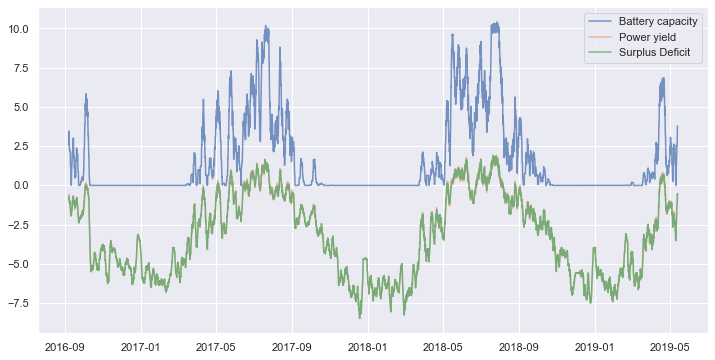

In [209]:
# plot battery capacity and power yield in same plot with plotly
import seaborn as sns
sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery["timeslot"], moving_average(series_battery["battery_capacity"], 80), label="Battery capacity", alpha=0.75)
ax.plot(series_battery["timeslot"], moving_average(series_battery["power_yield"], 80), label="Power yield", alpha=0.5)
ax.plot(series_battery["timeslot"], moving_average(series_battery["surplus_deficit"], 80), label="Surplus Deficit", alpha=0.75)
ax.legend()
plt.show()

## Estimate cost with battery and with logic

if next hour's estimated cost is higher than our current - we wait discharging our battery

In [257]:
# Initialise battery
battery = Battery(max_capacity=12)

# Define logic 
def price_optimisation_logic(row, battery):

    power_yield = row["power_yield"]
    hour = row["timeslot"].hour


    peak_hours = [8, 9, 10, 11, 16, 17, 18, 19]
    # if hour is in peak hours we sell all the power we have and produce
    if hour in peak_hours:
        if power_yield >= 0:
            current_charge = battery.get_current_capacity()
            current_charge += power_yield
            battery.current_capacity = 0
            row["surplus_deficit"] = current_charge
        else:
            battery.charge(power_yield)
            surplus = battery.get_surplus_deficit()
            if surplus >= 0:
                remaining_capacity = battery.get_current_capacity()
                battery.current_capacity = 0
                row["surplus_deficit"] = remaining_capacity
            else:
                row["surplus_deficit"] = battery.get_surplus_deficit()
    else:
        if power_yield >= 0:
            battery.charge(power_yield)
            if battery.get_current_capacity() != battery.get_max_capacity():
                buy = -(battery.get_max_capacity() - battery.get_current_capacity())
                battery.current_capacity = battery.get_max_capacity()

                row["surplus_deficit"] = buy
            else:
                row["surplus_deficit"] = battery.get_surplus_deficit()

        else:
            row["surplus_deficit"] = power_yield - (battery.get_max_capacity() - battery.get_current_capacity())
    
    row["battery_capacity"] = battery.get_current_capacity()
    return row

In [258]:
series_battery_logic = logic_rollout(series_merge.copy(), battery, price_optimisation_logic, get_price)

In [259]:
print_price_summary(series_battery_logic)

Cost for period: 2016-09-04 22:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  187378.0  NOK without VAT
Average cost per year is: 69697.0 NOK without VAT
Number of kwh purchased in the period: 224922.0
Average number of kwh purchased per year: 83662.16540077225


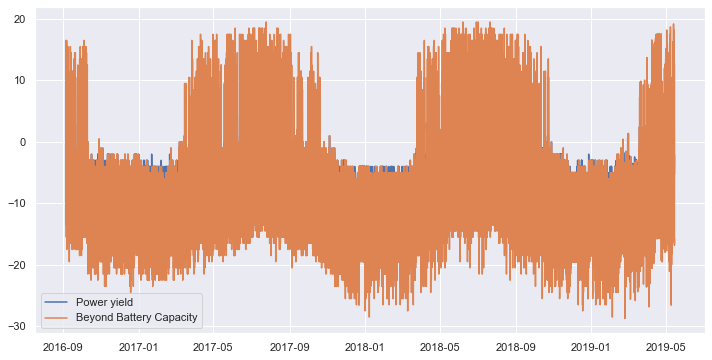

In [153]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(series_battery_logic["timeslot"], series_battery_logic["battery_capacity"], label="Battery capacity")
ax.plot(series_battery_logic["timeslot"], series_battery_logic["power_yield"], label="Power yield")
ax.plot(series_battery_logic["timeslot"], series_battery_logic["surplus_deficit"], label="Beyond Battery Capacity")
ax.legend()
plt.show()

# Tariff optimisation

In [260]:
# Initialise battery
battery = Battery(max_capacity=12)

# Define logic 
def tariff_optimisation_logic(row, battery):

    power_yield = row["power_yield"]
    hour = row["timeslot"].hour
    peak_hours = [8, 9, 10, 11, 16, 17, 18, 19]

    deficit = power_yield < 0


    # If production
    if power_yield >= 0:
        # Charge battery with surplus
        battery.charge(power_yield)


    # If we are in peak hours
    if hour in peak_hours:
        # Discharge battery if deficit
        if deficit:
            battery.charge(power_yield)
    else: 

        # Initialise power_to_buy to 0
        power_to_buy = 0
        # If battery is not fully charged 
        if battery.get_current_capacity() != battery.get_max_capacity():
            # Charge battery
            power_to_buy = battery.get_max_capacity() - battery.get_current_capacity()
            battery.charge(power_to_buy) 


        if deficit: 
            if deficit:
                battery.surplus_deficit = -power_to_buy + power_yield
            else: 
                battery.surplus_deficit = -power_to_buy


    row["surplus_deficit"] = battery.get_surplus_deficit()
    row["battery_capacity"] = battery.get_current_capacity()

    return row

In [261]:
series_battery_logic_TO = logic_rollout(series_merge.copy(), battery, tariff_optimisation_logic, get_price)

In [262]:
print_price_summary(series_battery_logic_TO)

Cost for period: 2016-09-04 22:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  66437.0  NOK without VAT
Average cost per year is: 24712.0 NOK without VAT
Number of kwh purchased in the period: 76332.0
Average number of kwh purchased per year: 28392.511223320744


# Plot cummulative price 

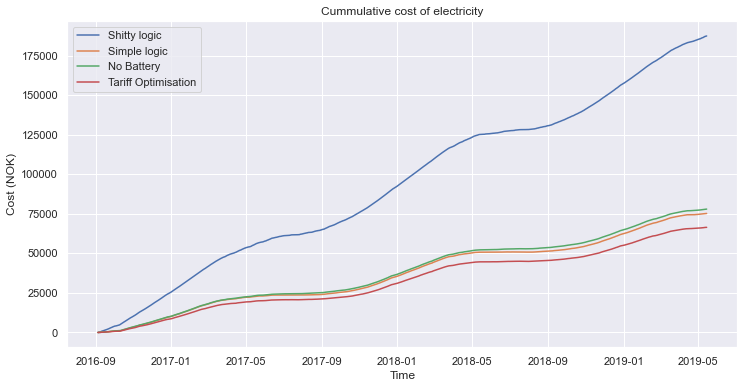

In [263]:
# plot cummulative price
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery_logic["timeslot"], series_battery_logic["price_cummulative"], label="Shitty logic")
ax.plot(series_battery["timeslot"], series_battery["price_cummulative"], label="Simple logic")
ax.plot(series_no_battery["timeslot"], series_no_battery["price_cummulative"], label="No Battery")
ax.plot(series_battery_logic_TO["timeslot"], series_battery_logic_TO["price_cummulative"], label="Tariff Optimisation")

ax.set_xlabel('Time')
ax.set_ylabel('Cost (NOK)')
ax.set_title('Cummulative cost of electricity')

ax.legend()
plt.show()


## Savings percentage barplot

{'Simple logic': 3.519561352715349, 'Shitty logic': -140.3359965429934, 'Tariff optimisation': 14.786071568695103}


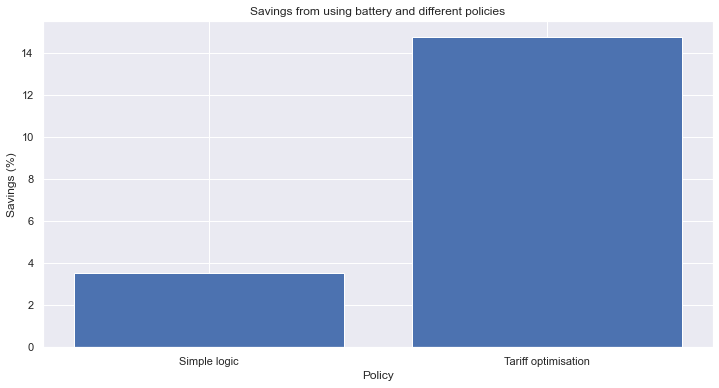

In [313]:
series_list = {"Simple logic": series_battery, "Shitty logic": series_battery_logic, "Tariff optimisation": series_battery_logic_TO}

savings_percentage_dict = {}

# Create a savings percentage dictionary
for name, series in series_list.items():
    series_price_sum = series["price"].sum()
    series_no_battery_price_sum = series_no_battery["price"].sum()
    savings_percentage = ((series_no_battery_price_sum-series_price_sum)/series_no_battery_price_sum)*100
    savings_percentage_dict[name] = savings_percentage
print(savings_percentage_dict)


# Drop "shitty logic" from savings_percentage_dict dict
del savings_percentage_dict["Shitty logic"]


# plot barplot of savings_percentage_dict
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(list(savings_percentage_dict.keys()), list(savings_percentage_dict.values()))
ax.set_xlabel('Policy')
ax.set_ylabel('Savings (%)')
ax.set_title('Savings from using battery and different policies')
plt.show()
